In [9]:
from qiskit import IBMQ

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import IntegerComparator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI
from qiskit.providers.ibmq import least_busy
from qiskit import execute, Aer
from qiskit.qasm import pi

import math

from qiskit.primitives import BackendSampler

In [17]:
num = 5 #株の数（もしくは変動日数）
theta = math.pi/2 #株の上下変動のしやすさ
lgd = [8,9,10,11,12]

In [11]:
qc = QuantumCircuit(num)

for i in range(num):
    qc.ry(theta,i)

qc_measure = qc.measure_all(inplace=False)

qc.draw()

┌─────────┐
q_0: ┤ Ry(π/2) ├
     ├─────────┤
q_1: ┤ Ry(π/2) ├
     ├─────────┤
q_2: ┤ Ry(π/2) ├
     ├─────────┤
q_3: ┤ Ry(π/2) ├
     ├─────────┤
q_4: ┤ Ry(π/2) ├
     └─────────┘

In [12]:
from qiskit.circuit.library import WeightedAdder
from qiskit.circuit.library import LinearAmplitudeFunction

agg = WeightedAdder(num, [8,9,10,11,12])

qr_state = QuantumRegister(qc.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
cr = ClassicalRegister(agg.num_sum_qubits, "value")

L_sum_state = QuantumCircuit(qr_state, qr_sum, qr_carry, cr)

# load the variable
L_sum_state.append(qc.to_gate(), qr_state)

# aggregate
L_sum_state.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

L_sum_state.measure(qr_sum[:],cr[:])

L_sum_state.draw()

┌──────────────┐┌─────────┐                  
state_0: ┤0             ├┤0        ├──────────────────
         │              ││         │                  
state_1: ┤1             ├┤1        ├──────────────────
         │              ││         │                  
state_2: ┤2 circuit-212 ├┤2        ├──────────────────
         │              ││         │                  
state_3: ┤3             ├┤3        ├──────────────────
         │              ││         │                  
state_4: ┤4             ├┤4        ├──────────────────
         └──────────────┘│         │┌─┐               
  sum_0: ────────────────┤5        ├┤M├───────────────
                         │         │└╥┘┌─┐            
  sum_1: ────────────────┤6        ├─╫─┤M├────────────
                         │         │ ║ └╥┘┌─┐         
  sum_2: ────────────────┤7        ├─╫──╫─┤M├─────────
                         │         │ ║  ║ └╥┘┌─┐      
  sum_3: ────────────────┤8  adder ├─╫──╫──╫─┤M├──────
                         │         │ ║  ║  ║ └╥┘┌─┐   
  sum_4: ────────────────┤9        ├─╫──╫──╫──╫─┤M├───
                         │         │ ║  ║  ║  ║ └╥┘┌─┐
  sum_5: ────────────────┤10       ├─╫──╫──╫──╫──╫─┤M├
                         │         │ ║  ║  ║  ║  ║ └╥┘
carry_0: ────────────────┤11       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_1: ────────────────┤12       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_2: ────────────────┤13       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_3: ────────────────┤14       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_4: ────────────────┤15       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_5: ────────────────┤16       ├─╫──╫──╫──╫──╫──╫─
                         └─────────┘ ║  ║  ║  ║  ║  ║ 
value: 6/════════════════════════════╩══╩══╩══╩══╩══╩═
                                     0  1  2  3  4  5

In [8]:
L_sum_state.decompose().draw()

┌─────────┐┌───────────────┐                  
state_0: ┤ Ry(π/2) ├┤0              ├──────────────────
         ├─────────┤│               │                  
state_1: ┤ Ry(π/2) ├┤1              ├──────────────────
         ├─────────┤│               │                  
state_2: ┤ Ry(π/2) ├┤2              ├──────────────────
         ├─────────┤│               │                  
state_3: ┤ Ry(π/2) ├┤3              ├──────────────────
         ├─────────┤│               │                  
state_4: ┤ Ry(π/2) ├┤4              ├──────────────────
         └─────────┘│               │┌─┐               
  sum_0: ───────────┤5              ├┤M├───────────────
                    │               │└╥┘┌─┐            
  sum_1: ───────────┤6              ├─╫─┤M├────────────
                    │               │ ║ └╥┘┌─┐         
  sum_2: ───────────┤7              ├─╫──╫─┤M├─────────
                    │               │ ║  ║ └╥┘┌─┐      
  sum_3: ───────────┤8  circuit-165 ├─╫──╫──╫─┤M├──────
                    │               │ ║  ║  ║ └╥┘┌─┐   
  sum_4: ───────────┤9              ├─╫──╫──╫──╫─┤M├───
                    │               │ ║  ║  ║  ║ └╥┘┌─┐
  sum_5: ───────────┤10             ├─╫──╫──╫──╫──╫─┤M├
                    │               │ ║  ║  ║  ║  ║ └╥┘
carry_0: ───────────┤11             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_1: ───────────┤12             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_2: ───────────┤13             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_3: ───────────┤14             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_4: ───────────┤15             ├─╫──╫──╫──╫──╫──╫─
                    │               │ ║  ║  ║  ║  ║  ║ 
carry_5: ───────────┤16             ├─╫──╫──╫──╫──╫──╫─
                    └───────────────┘ ║  ║  ║  ║  ║  ║ 
value: 6/═════════════════════════════╩══╩══╩══╩══╩══╩═
                                      0  1  2  3  4  5

In [13]:
sampler = Sampler()
job = sampler.run(L_sum_state)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [14]:
qubit_state_L = []

for i, prob in binary_probabilities.items():
    print(i,prob)
    qubit_state_L.append([i,prob])

qubit_state_L.sort()

100110 0.0283203125
010111 0.0439453125
100000 0.03515625
010011 0.0654296875
101001 0.0234375
001011 0.037109375
011100 0.0380859375
101000 0.03125
001010 0.0244140625
001000 0.033203125
010001 0.0302734375
010101 0.064453125
001001 0.02734375
011011 0.0380859375
001100 0.0244140625
010110 0.0205078125
011111 0.0517578125
100001 0.029296875
101010 0.025390625
011101 0.0712890625
000000 0.0244140625
010100 0.052734375
110010 0.0302734375
100111 0.029296875
010010 0.037109375
011110 0.0830078125


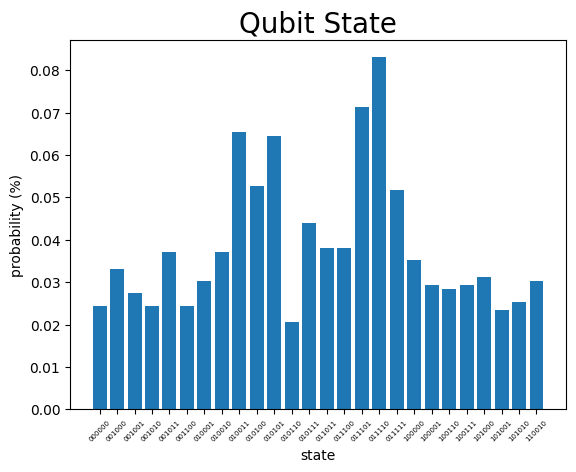

In [15]:
# plot probabilities of each states
q_state_L = []
q_prob_L = []
for state in qubit_state_L:
    q_state_L.append(state[0])
    q_prob_L.append(state[1])

plt.bar(q_state_L,q_prob_L)
#plt.legend(fontsize=15)
plt.xlabel("state", size=10)
plt.ylabel("probability (%)", size=10)
plt.title("Qubit State", size=20)
plt.xticks(size=5,rotation=45)
plt.yticks(size=10)
plt.show()

In [18]:
from qiskit.circuit.library import LinearAmplitudeFunction

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [20]:
# define the registers for convenience and readability
qr_state = QuantumRegister(qc.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
qr_obj = QuantumRegister(1, "objective")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

# load the random variable
state_preparation.append(qc.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.draw()

┌──────────────┐┌─────────┐      ┌────────────┐
  state_0: ┤0             ├┤0        ├──────┤0           ├
           │              ││         │      │            │
  state_1: ┤1             ├┤1        ├──────┤1           ├
           │              ││         │      │            │
  state_2: ┤2 circuit-212 ├┤2        ├──────┤2           ├
           │              ││         │      │            │
  state_3: ┤3             ├┤3        ├──────┤3           ├
           │              ││         │      │            │
  state_4: ┤4             ├┤4        ├──────┤4           ├
           └──────────────┘│         │┌────┐│            │
objective: ────────────────┤         ├┤6   ├┤            ├
                           │         ││    ││            │
    sum_0: ────────────────┤5        ├┤0   ├┤5           ├
                           │         ││    ││            │
    sum_1: ────────────────┤6        ├┤1   ├┤6           ├
                           │         ││    ││            │
    sum_2: ────────────────┤7        ├┤2 F ├┤7           ├
                           │   adder ││    ││   adder_dg │
    sum_3: ────────────────┤8        ├┤3   ├┤8           ├
                           │         ││    ││            │
    sum_4: ────────────────┤9        ├┤4   ├┤9           ├
                           │         ││    ││            │
    sum_5: ────────────────┤10       ├┤5   ├┤10          ├
                           │         │└────┘│            │
  carry_0: ────────────────┤11       ├──────┤11          ├
                           │         │      │            │
  carry_1: ────────────────┤12       ├──────┤12          ├
                           │         │      │            │
  carry_2: ────────────────┤13       ├──────┤13          ├
                           │         │      │            │
  carry_3: ────────────────┤14       ├──────┤14          ├
                           │         │      │            │
  carry_4: ────────────────┤15       ├──────┤15          ├
                           │         │      │            │
  carry_5: ────────────────┤16       ├──────┤16          ├
                           └─────────┘      └────────────┘

In [21]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [23]:
# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Operator Value:  0.5176
Mapped Operator value: 27.2381


In [25]:
# set target precision and confidence level
alpha = 0.1
epsilon = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result = ae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Estimated value:	19.5087
Confidence interval: 	[14.5917, 24.4256]
